In [1]:
import json
import torch
from mh_within_gibbs import gibbs_sampling
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
f = open('graphs/1.json', 'rb')
g1 = json.load(f)
f.close()
f = open('graphs/2.json', 'rb')
g2 = json.load(f)
f.close()
f = open('graphs/3.json', 'rb')
g3 = json.load(f)
f.close()
f = open('graphs/4.json', 'rb')
g4 = json.load(f)
f.close()

In [209]:
# hamiltonian_monte_carlo
# TODO: clean up ENV behaviour so that all this sample_from_graph, jll, deterministic_eval
# can be imported

import torch 
from primitives import eval_env
from graph_utils import topological_sort
import copy

ENV = eval_env()


def hmc(graph, S, X0=None, T=20, epsilon=0.1, m=1, return_samples=False, report_acceptance_rate=False):
    # NOTE: for now, assume that len(X) is dimensionality of R
    # this may not be the case if element of X are vectors themselves
    
    if return_samples:
        samples = [None]*S
    if report_acceptance_rate:
        accepts = 0
    
    jlls = [None]*S
    ret_vals = [None]*S

    if X0 is None:
        X0 = sample_from_prior(graph)

    Xprev = X0
    Xdim = len(X0)

    ret_expr = graph[2]

    R_dist = torch.distributions.MultivariateNormal(torch.zeros(Xdim), m*torch.eye(Xdim))
    unif = torch.distributions.uniform.Uniform(0, 1)

    for s in range(S):
        # get a new R
        R_vals = R_dist.sample()
        R = dict(zip(Xprev.keys(), R_vals))
        # perform leapfrog integration WITH COPIES!
        """
        print("\n~~~~~~~ OUTER LOOP BEGIN~~~~~~~~")
        print('X')
        print(Xprev)
        print('R')
        print(R)
        """
        Xprime, Rprime = leapfrog(graph, copy.deepcopy(Xprev), copy.deepcopy(R), T, epsilon)
        """
        print('Xprime')
        print(Xprime)
        print('Rprime')
        print(Rprime)
        print("CHECK THIS SHIT OUT !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print('X')
        print(Xprev)
        print('R')
        print(R)
        print("~~~~~~~~ OUTER LOOP END~~~~~~~~\n")
        """
        # compute acceptance values
        u = unif.sample()
        alpha = accept(graph, Xprev, R, Xprime, Rprime, m)
        print('alpha')
        print(alpha)
        # based on acceptance values, choose which X to keep
        if u < alpha:
            if report_acceptance_rate:
                accepts +=1
            Xkeep = Xprime
        else:
            Xkeep = Xprev

        # store appropriate things
        if return_samples:
            samples[s] = Xkeep
        ret_vals[s] = deterministic_evaluate(ret_expr, Xkeep)[0]
        jlls[s] = joint_log_likelihood(Xkeep, graph)

        # update Xprev
        Xprev = Xkeep

    if report_acceptance_rate:
        print("Acceptance rate: {}".format(accepts/S))

    if return_samples:
        return ret_vals, jlls, samples
    else:
        return ret_vals, jlls


def leapfrog(graph, X, R, T, epsilon):
    """
    print("\n~~~~~~~~ BEGIN LEAPFROG ~~~~~~~~~")
    print('X before')
    print(X)
    print('R before')
    print(R)
    """
    gradU = get_grad_U(graph, X)
    R = R_update(R, gradU, epsilon, half_step=True)

    for t in range(T-1):
        X = X_update(X, R, epsilon)
        gradU = get_grad_U(graph, X)
        R = R_update(R, gradU, epsilon)

    X = X_update(X, R, epsilon)
    gradU = get_grad_U(graph, X)
    R = R_update(R, gradU, epsilon, half_step=True)
    """
    print('X after')
    print(X)
    print('R after')
    print(R)
    print("~~~~~~~~ END LEAPFROG ~~~~~~~~~\n")    
    """
    return X, R


def get_grad_U(graph, X):

    P = graph[1]['P']
    Y = {k: torch.tensor(v).float() for k, v in graph[1]['Y'].items()}
    V = {**X, **Y}
    Vkeys = list(V.keys())
    U = 0
    for v in Vkeys:
        V[v].requires_grad=True
        if V[v].grad != None:
            V[v].grad.zero_()
    for v in Vkeys:
        expr = P[v][1]
        p_v, _ = deterministic_evaluate(expr, V)
        U += p_v.log_prob(V[v])

    U *= -1
    U.backward()
    gradU = {key: value.grad for key, value in X.items()}

    return gradU


def R_update(R, gradU, epsilon, half_step=False):
    
    keys = list(R.keys())
    if half_step:
        epsilon = 0.5*epsilon

    for r in keys:
        R[r] -= epsilon*gradU[r]

    return R


def X_update(X, R, epsilon):
    keys = list(X.keys())

    for x in keys:
        X[x].requires_grad = False
        X[x] += epsilon*R[x]

    return X


def accept(graph, X, R, Xprime, Rprime, m):
    """
    print("\n~~~~~~ INSIDE ACCEPT ~~~~~~")
    print('X')
    print(X)
    print('R')
    print(R)
    print('Xprime')
    print(Xprime)
    print('Rprime')
    print(Rprime)
    """
    K = 0
    for r in R.values():
        K += 0.5*r**2/m
    U = -1*joint_log_likelihood(X, graph)
    H = K + U

    Kprime = 0 
    for r in Rprime.values():
        Kprime += 0.5*r**2/m 
    Uprime = -1*joint_log_likelihood(Xprime, graph)
    Hprime = Kprime + Uprime
    """
    print('H')
    print(H)
    print('Hprime')
    print(Hprime)
    print("~~~~~~~~~ END ACCEPT ~~~~~~~~~~~~\n")
    """
    return torch.exp(-Hprime + H)

def sample_from_prior(graph):
    # get contents of graph
    fn_defs = graph[0]
    V = graph[1]['V']
    A = graph[1]['A']
    P = graph[1]['P']
    Y = graph[1]['Y']
    ret_vals = graph[2]
    
    # deal with fn_defs
    global ENV
    ENV = eval_env()
    for defn in fn_defs.items():
        f_name = defn[0]
        f_v_is = defn[1][1]
        f_expr = defn[1][2]
        ENV.update({f_name: (f_v_is, f_expr)})
    
    # get sorted V
    sorted_V = topological_sort(A, V)

    # compute each value in order
    l = {}
    for v in sorted_V:
        task, expr = P[v][0], P[v][1]
        if task == "sample*":
            dist, _ = deterministic_evaluate(expr, l)
            l.update({v: dist.sample()})

    return l


def joint_log_likelihood(X, graph):
    P = graph[1]['P']
    Y = {k: torch.tensor(v).float() for k, v in graph[1]['Y'].items()}
    V = {**X, **Y}
    Vkeys = list(V.keys())
    jll = 0

    for v in Vkeys:
        expr = P[v][1]
        p_v, _ = deterministic_evaluate(expr, V)
        jll += p_v.log_prob(V[v])

    return jll


def deterministic_evaluate(e, l, sig=None):
    # variable reference OR procedure OR just a string
    if isinstance(e, str):        
        # global procedures take precedence over locally defined vars
        if e in ENV:
            return ENV[e], sig
        elif e in l:
            return l[e], sig
        # could allow for hashmaps with string keys; for debugging setting this to fail
        else:
            assert False, "Unknown symbol: {}".format(e)
    # constant number
    elif isinstance(e, (int, float)):   
        return torch.tensor(float(e)), sig
    # if statements
    elif e[0] == 'if':
        (_, test, conseq, alt) = e
        exp = (conseq if deterministic_evaluate(test, l)[0] else alt)
        return deterministic_evaluate(exp, l)
    # let statements
    elif e[0] == 'let':
        # get symbol
        symbol = e[1][0]
        # get value of e1
        value, _ = deterministic_evaluate(e[1][1], l)
        # evaluate e2 with value 
        return deterministic_evaluate(e[2], {**l, symbol: value})
    # sample statement
    if e[0] == 'sample':
        dist = deterministic_evaluate(e[1], l)[0]
        # make sure it is a distribution object
        assert getattr(dist, '__module__', None).split('.')[:2] == ['torch', 'distributions']
        return dist.sample(), sig
    # obsere statements
    # TODO: change this, maybe in this hw or for hw3
    if e[0] == 'observe':
        dist = deterministic_evaluate(e[1], l)[0] # get dist
        y = deterministic_evaluate(e[2], l)[0]    # get observed value
        # make sure it is a distribution object
        assert getattr(dist, '__module__', None).split('.')[:2] == ['torch', 'distributions']
        # TODO: do something with observed value
        return dist.sample(), sig
    # procedure call, either primitive or user-defined
    else:
        result = deterministic_evaluate(e[0], l)
        proc, sig = result
        # primitives are functions
        if callable(proc):
            args = [deterministic_evaluate(arg, l)[0] for arg in e[1:]]
            result, sig = proc(*args), sig
            return result, sig
        # user defined functions are not
        else:
            # as written in algorithm 6
            v_is, e0 = proc 
            assert(len(v_is) == len(e[1:]))
            c_is = [deterministic_evaluate(arg, l)[0] for arg in e[1:]]
            l_proc = dict(zip(v_is, c_is))
            return deterministic_evaluate(e0, {**l, **l_proc})



In [220]:
ret_vals, jlls = hmc(g2, 1000, report_acceptance_rate=True)

alpha
tensor(inf, grad_fn=<ExpBackward>)
alpha
tensor(6.1094, grad_fn=<ExpBackward>)
alpha
tensor(1.0293, grad_fn=<ExpBackward>)
alpha
tensor(1.0036, grad_fn=<ExpBackward>)
alpha
tensor(0.9824, grad_fn=<ExpBackward>)
alpha
tensor(1.0184, grad_fn=<ExpBackward>)
alpha
tensor(0.7862, grad_fn=<ExpBackward>)
alpha
tensor(1.2652, grad_fn=<ExpBackward>)
alpha
tensor(0.9968, grad_fn=<ExpBackward>)
alpha
tensor(0.9595, grad_fn=<ExpBackward>)
alpha
tensor(0.9993, grad_fn=<ExpBackward>)
alpha
tensor(0.9522, grad_fn=<ExpBackward>)
alpha
tensor(0.9967, grad_fn=<ExpBackward>)
alpha
tensor(1.1055, grad_fn=<ExpBackward>)
alpha
tensor(0.8635, grad_fn=<ExpBackward>)
alpha
tensor(1.1473, grad_fn=<ExpBackward>)
alpha
tensor(0.8069, grad_fn=<ExpBackward>)
alpha
tensor(1.2480, grad_fn=<ExpBackward>)
alpha
tensor(0.9635, grad_fn=<ExpBackward>)
alpha
tensor(0.8565, grad_fn=<ExpBackward>)
alpha
tensor(1.0387, grad_fn=<ExpBackward>)
alpha
tensor(1.1235, grad_fn=<ExpBackward>)
alpha
tensor(0.9537, grad_fn=<ExpBa

alpha
tensor(1.3106, grad_fn=<ExpBackward>)
alpha
tensor(0.9053, grad_fn=<ExpBackward>)
alpha
tensor(1.0794, grad_fn=<ExpBackward>)
alpha
tensor(0.9591, grad_fn=<ExpBackward>)
alpha
tensor(0.7285, grad_fn=<ExpBackward>)
alpha
tensor(1.4654, grad_fn=<ExpBackward>)
alpha
tensor(0.6983, grad_fn=<ExpBackward>)
alpha
tensor(1.4134, grad_fn=<ExpBackward>)
alpha
tensor(0.8416, grad_fn=<ExpBackward>)
alpha
tensor(1.2056, grad_fn=<ExpBackward>)
alpha
tensor(0.9171, grad_fn=<ExpBackward>)
alpha
tensor(1.0521, grad_fn=<ExpBackward>)
alpha
tensor(1.0216, grad_fn=<ExpBackward>)
alpha
tensor(0.6651, grad_fn=<ExpBackward>)
alpha
tensor(1.5070, grad_fn=<ExpBackward>)
alpha
tensor(0.8500, grad_fn=<ExpBackward>)
alpha
tensor(1.1611, grad_fn=<ExpBackward>)
alpha
tensor(1.0042, grad_fn=<ExpBackward>)
alpha
tensor(1.0169, grad_fn=<ExpBackward>)
alpha
tensor(1.0033, grad_fn=<ExpBackward>)
alpha
tensor(0.8196, grad_fn=<ExpBackward>)
alpha
tensor(0.9681, grad_fn=<ExpBackward>)
alpha
tensor(1.0008, grad_fn=<Ex

alpha
tensor(0.8298, grad_fn=<ExpBackward>)
alpha
tensor(1.2412, grad_fn=<ExpBackward>)
alpha
tensor(1.0123, grad_fn=<ExpBackward>)
alpha
tensor(1.0102, grad_fn=<ExpBackward>)
alpha
tensor(0.9262, grad_fn=<ExpBackward>)
alpha
tensor(0.6764, grad_fn=<ExpBackward>)
alpha
tensor(1.6367, grad_fn=<ExpBackward>)
alpha
tensor(0.8670, grad_fn=<ExpBackward>)
alpha
tensor(1.1339, grad_fn=<ExpBackward>)
alpha
tensor(0.9981, grad_fn=<ExpBackward>)
alpha
tensor(0.6621, grad_fn=<ExpBackward>)
alpha
tensor(1.5209, grad_fn=<ExpBackward>)
alpha
tensor(0.7347, grad_fn=<ExpBackward>)
alpha
tensor(0.4658, grad_fn=<ExpBackward>)
alpha
tensor(2.5630, grad_fn=<ExpBackward>)
alpha
tensor(1.1494, grad_fn=<ExpBackward>)
alpha
tensor(0.9651, grad_fn=<ExpBackward>)
alpha
tensor(1.0432, grad_fn=<ExpBackward>)
alpha
tensor(1.0045, grad_fn=<ExpBackward>)
alpha
tensor(0.8383, grad_fn=<ExpBackward>)
alpha
tensor(1.1910, grad_fn=<ExpBackward>)
alpha
tensor(1.0035, grad_fn=<ExpBackward>)
alpha
tensor(0.9720, grad_fn=<Ex

alpha
tensor(0.9956, grad_fn=<ExpBackward>)
alpha
tensor(0.9640, grad_fn=<ExpBackward>)
alpha
tensor(0.5576, grad_fn=<ExpBackward>)
alpha
tensor(1.7185, grad_fn=<ExpBackward>)
alpha
tensor(1.0874, grad_fn=<ExpBackward>)
alpha
tensor(0.9528, grad_fn=<ExpBackward>)
alpha
tensor(1.0147, grad_fn=<ExpBackward>)
alpha
tensor(0.8406, grad_fn=<ExpBackward>)
alpha
tensor(0.9753, grad_fn=<ExpBackward>)
alpha
tensor(1.0280, grad_fn=<ExpBackward>)
alpha
tensor(0.9310, grad_fn=<ExpBackward>)
alpha
tensor(1.1097, grad_fn=<ExpBackward>)
alpha
tensor(0.9613, grad_fn=<ExpBackward>)
alpha
tensor(1.0412, grad_fn=<ExpBackward>)
alpha
tensor(0.8047, grad_fn=<ExpBackward>)
alpha
tensor(1.1728, grad_fn=<ExpBackward>)
alpha
tensor(1.0325, grad_fn=<ExpBackward>)
alpha
tensor(0.9710, grad_fn=<ExpBackward>)
alpha
tensor(1.0107, grad_fn=<ExpBackward>)
alpha
tensor(0.9943, grad_fn=<ExpBackward>)
alpha
tensor(1.0117, grad_fn=<ExpBackward>)
alpha
tensor(0.7367, grad_fn=<ExpBackward>)
alpha
tensor(1.3953, grad_fn=<Ex

alpha
tensor(0.9622, grad_fn=<ExpBackward>)
alpha
tensor(0.8809, grad_fn=<ExpBackward>)
alpha
tensor(1.1759, grad_fn=<ExpBackward>)
alpha
tensor(1.0084, grad_fn=<ExpBackward>)
alpha
tensor(0.9987, grad_fn=<ExpBackward>)
alpha
tensor(0.7830, grad_fn=<ExpBackward>)
alpha
tensor(0.6803, grad_fn=<ExpBackward>)
alpha
tensor(1.3674, grad_fn=<ExpBackward>)
alpha
tensor(1.0329, grad_fn=<ExpBackward>)
alpha
tensor(1.0466, grad_fn=<ExpBackward>)
alpha
tensor(0.7054, grad_fn=<ExpBackward>)
alpha
tensor(1.4129, grad_fn=<ExpBackward>)
alpha
tensor(0.4886, grad_fn=<ExpBackward>)
alpha
tensor(0.9098, grad_fn=<ExpBackward>)
alpha
tensor(1.1021, grad_fn=<ExpBackward>)
alpha
tensor(0.8591, grad_fn=<ExpBackward>)
alpha
tensor(1.0633, grad_fn=<ExpBackward>)
alpha
tensor(0.6237, grad_fn=<ExpBackward>)
alpha
tensor(0.9602, grad_fn=<ExpBackward>)
alpha
tensor(0.9120, grad_fn=<ExpBackward>)
alpha
tensor(1.2502, grad_fn=<ExpBackward>)
alpha
tensor(0.9958, grad_fn=<ExpBackward>)
alpha
tensor(0.5757, grad_fn=<Ex

alpha
tensor(0.5959, grad_fn=<ExpBackward>)
alpha
tensor(0.4098, grad_fn=<ExpBackward>)
alpha
tensor(0.8188, grad_fn=<ExpBackward>)
alpha
tensor(0.9321, grad_fn=<ExpBackward>)
alpha
tensor(1.2941, grad_fn=<ExpBackward>)
alpha
tensor(0.4078, grad_fn=<ExpBackward>)
alpha
tensor(1.6167, grad_fn=<ExpBackward>)
alpha
tensor(1.5322, grad_fn=<ExpBackward>)
alpha
tensor(0.9852, grad_fn=<ExpBackward>)
alpha
tensor(0.3721, grad_fn=<ExpBackward>)
alpha
tensor(0.9817, grad_fn=<ExpBackward>)
alpha
tensor(0.9514, grad_fn=<ExpBackward>)
alpha
tensor(0.9598, grad_fn=<ExpBackward>)
alpha
tensor(0.9383, grad_fn=<ExpBackward>)
alpha
tensor(1.1058, grad_fn=<ExpBackward>)
alpha
tensor(1.0973, grad_fn=<ExpBackward>)
alpha
tensor(0.9448, grad_fn=<ExpBackward>)
alpha
tensor(0.8238, grad_fn=<ExpBackward>)
alpha
tensor(1.2374, grad_fn=<ExpBackward>)
alpha
tensor(0.9976, grad_fn=<ExpBackward>)
alpha
tensor(0.3587, grad_fn=<ExpBackward>)
alpha
tensor(2.7911, grad_fn=<ExpBackward>)
alpha
tensor(1.0156, grad_fn=<Ex

In [221]:
ret_vals = torch.stack(ret_vals)

In [222]:
torch.mean(ret_vals, dim=0)

tensor([ 2.1446, -0.4868], grad_fn=<MeanBackward1>)

In [214]:
ret_vals, jlls = hmc(g1, 1000, report_acceptance_rate=True)

alpha
tensor(1.0790, grad_fn=<ExpBackward>)
alpha
tensor(1.0420, grad_fn=<ExpBackward>)
alpha
tensor(1.0070, grad_fn=<ExpBackward>)
alpha
tensor(0.9989, grad_fn=<ExpBackward>)
alpha
tensor(0.9972, grad_fn=<ExpBackward>)
alpha
tensor(1.0019, grad_fn=<ExpBackward>)
alpha
tensor(1.0002, grad_fn=<ExpBackward>)
alpha
tensor(1.0019, grad_fn=<ExpBackward>)
alpha
tensor(0.9987, grad_fn=<ExpBackward>)
alpha
tensor(1.0012, grad_fn=<ExpBackward>)
alpha
tensor(0.9995, grad_fn=<ExpBackward>)
alpha
tensor(1.0005, grad_fn=<ExpBackward>)
alpha
tensor(0.9998, grad_fn=<ExpBackward>)
alpha
tensor(0.9954, grad_fn=<ExpBackward>)
alpha
tensor(1.0030, grad_fn=<ExpBackward>)
alpha
tensor(1.0016, grad_fn=<ExpBackward>)
alpha
tensor(1.0001, grad_fn=<ExpBackward>)
alpha
tensor(0.9979, grad_fn=<ExpBackward>)
alpha
tensor(1.0020, grad_fn=<ExpBackward>)
alpha
tensor(1.0000, grad_fn=<ExpBackward>)
alpha
tensor(0.9994, grad_fn=<ExpBackward>)
alpha
tensor(0.9985, grad_fn=<ExpBackward>)
alpha
tensor(1.0022, grad_fn=<Ex

alpha
tensor(0.9996, grad_fn=<ExpBackward>)
alpha
tensor(1.0007, grad_fn=<ExpBackward>)
alpha
tensor(0.9988, grad_fn=<ExpBackward>)
alpha
tensor(0.9907, grad_fn=<ExpBackward>)
alpha
tensor(1.0065, grad_fn=<ExpBackward>)
alpha
tensor(1.0031, grad_fn=<ExpBackward>)
alpha
tensor(1.0010, grad_fn=<ExpBackward>)
alpha
tensor(0.9906, grad_fn=<ExpBackward>)
alpha
tensor(1.0095, grad_fn=<ExpBackward>)
alpha
tensor(0.9975, grad_fn=<ExpBackward>)
alpha
tensor(1.0015, grad_fn=<ExpBackward>)
alpha
tensor(1.0006, grad_fn=<ExpBackward>)
alpha
tensor(0.9996, grad_fn=<ExpBackward>)
alpha
tensor(1.0003, grad_fn=<ExpBackward>)
alpha
tensor(0.9971, grad_fn=<ExpBackward>)
alpha
tensor(1.0025, grad_fn=<ExpBackward>)
alpha
tensor(1.0010, grad_fn=<ExpBackward>)
alpha
tensor(0.9999, grad_fn=<ExpBackward>)
alpha
tensor(1.0001, grad_fn=<ExpBackward>)
alpha
tensor(1.0000, grad_fn=<ExpBackward>)
alpha
tensor(0.9983, grad_fn=<ExpBackward>)
alpha
tensor(1.0009, grad_fn=<ExpBackward>)
alpha
tensor(0.9995, grad_fn=<Ex

alpha
tensor(1.0010, grad_fn=<ExpBackward>)
alpha
tensor(0.9999, grad_fn=<ExpBackward>)
alpha
tensor(1.0000, grad_fn=<ExpBackward>)
alpha
tensor(0.9959, grad_fn=<ExpBackward>)
alpha
tensor(1.0028, grad_fn=<ExpBackward>)
alpha
tensor(1.0012, grad_fn=<ExpBackward>)
alpha
tensor(0.9994, grad_fn=<ExpBackward>)
alpha
tensor(0.9985, grad_fn=<ExpBackward>)
alpha
tensor(0.9997, grad_fn=<ExpBackward>)
alpha
tensor(0.9953, grad_fn=<ExpBackward>)
alpha
tensor(1.0070, grad_fn=<ExpBackward>)
alpha
tensor(0.9999, grad_fn=<ExpBackward>)
alpha
tensor(0.9998, grad_fn=<ExpBackward>)
alpha
tensor(0.9973, grad_fn=<ExpBackward>)
alpha
tensor(1.0032, grad_fn=<ExpBackward>)
alpha
tensor(0.9997, grad_fn=<ExpBackward>)
alpha
tensor(1.0005, grad_fn=<ExpBackward>)
alpha
tensor(0.9997, grad_fn=<ExpBackward>)
alpha
tensor(0.9853, grad_fn=<ExpBackward>)
alpha
tensor(1.0088, grad_fn=<ExpBackward>)
alpha
tensor(1.0040, grad_fn=<ExpBackward>)
alpha
tensor(0.9959, grad_fn=<ExpBackward>)
alpha
tensor(1.0065, grad_fn=<Ex

alpha
tensor(1.0047, grad_fn=<ExpBackward>)
alpha
tensor(0.9991, grad_fn=<ExpBackward>)
alpha
tensor(1.0004, grad_fn=<ExpBackward>)
alpha
tensor(0.9998, grad_fn=<ExpBackward>)
alpha
tensor(1.0013, grad_fn=<ExpBackward>)
alpha
tensor(0.9994, grad_fn=<ExpBackward>)
alpha
tensor(1.0002, grad_fn=<ExpBackward>)
alpha
tensor(1.0003, grad_fn=<ExpBackward>)
alpha
tensor(0.9973, grad_fn=<ExpBackward>)
alpha
tensor(1.0027, grad_fn=<ExpBackward>)
alpha
tensor(0.9978, grad_fn=<ExpBackward>)
alpha
tensor(0.9983, grad_fn=<ExpBackward>)
alpha
tensor(1.0013, grad_fn=<ExpBackward>)
alpha
tensor(1.0011, grad_fn=<ExpBackward>)
alpha
tensor(1.0015, grad_fn=<ExpBackward>)
alpha
tensor(0.9998, grad_fn=<ExpBackward>)
alpha
tensor(1.0003, grad_fn=<ExpBackward>)
alpha
tensor(0.9992, grad_fn=<ExpBackward>)
alpha
tensor(1.0008, grad_fn=<ExpBackward>)
alpha
tensor(0.9997, grad_fn=<ExpBackward>)
alpha
tensor(1.0003, grad_fn=<ExpBackward>)
alpha
tensor(0.9945, grad_fn=<ExpBackward>)
alpha
tensor(1.0022, grad_fn=<Ex

alpha
tensor(0.9993, grad_fn=<ExpBackward>)
alpha
tensor(0.9995, grad_fn=<ExpBackward>)
alpha
tensor(1.0002, grad_fn=<ExpBackward>)
alpha
tensor(1.0007, grad_fn=<ExpBackward>)
alpha
tensor(1.0006, grad_fn=<ExpBackward>)
alpha
tensor(0.9999, grad_fn=<ExpBackward>)
alpha
tensor(0.9999, grad_fn=<ExpBackward>)
alpha
tensor(0.9982, grad_fn=<ExpBackward>)
alpha
tensor(0.9996, grad_fn=<ExpBackward>)
alpha
tensor(1.0014, grad_fn=<ExpBackward>)
alpha
tensor(1.0005, grad_fn=<ExpBackward>)
alpha
tensor(0.9952, grad_fn=<ExpBackward>)
alpha
tensor(1.0047, grad_fn=<ExpBackward>)
alpha
tensor(1.0001, grad_fn=<ExpBackward>)
alpha
tensor(1.0004, grad_fn=<ExpBackward>)
alpha
tensor(1.0000, grad_fn=<ExpBackward>)
alpha
tensor(0.9999, grad_fn=<ExpBackward>)
alpha
tensor(1.0002, grad_fn=<ExpBackward>)
alpha
tensor(0.9987, grad_fn=<ExpBackward>)
alpha
tensor(0.9983, grad_fn=<ExpBackward>)
alpha
tensor(1.0027, grad_fn=<ExpBackward>)
alpha
tensor(1.0003, grad_fn=<ExpBackward>)
alpha
tensor(1.0000, grad_fn=<Ex

alpha
tensor(0.9999, grad_fn=<ExpBackward>)
alpha
tensor(0.9995, grad_fn=<ExpBackward>)
alpha
tensor(0.9999, grad_fn=<ExpBackward>)
alpha
tensor(0.9999, grad_fn=<ExpBackward>)
alpha
tensor(1.0008, grad_fn=<ExpBackward>)
alpha
tensor(0.9998, grad_fn=<ExpBackward>)
alpha
tensor(0.9980, grad_fn=<ExpBackward>)
alpha
tensor(1.0007, grad_fn=<ExpBackward>)
alpha
tensor(0.9990, grad_fn=<ExpBackward>)
alpha
tensor(0.9984, grad_fn=<ExpBackward>)
alpha
tensor(1.0042, grad_fn=<ExpBackward>)
alpha
tensor(1.0000, grad_fn=<ExpBackward>)
alpha
tensor(1.0000, grad_fn=<ExpBackward>)
alpha
tensor(0.9992, grad_fn=<ExpBackward>)
alpha
tensor(1.0003, grad_fn=<ExpBackward>)
alpha
tensor(0.9975, grad_fn=<ExpBackward>)
alpha
tensor(1.0029, grad_fn=<ExpBackward>)
alpha
tensor(0.9999, grad_fn=<ExpBackward>)
alpha
tensor(1.0000, grad_fn=<ExpBackward>)
alpha
tensor(1.0002, grad_fn=<ExpBackward>)
alpha
tensor(1.0000, grad_fn=<ExpBackward>)
alpha
tensor(0.9997, grad_fn=<ExpBackward>)
alpha
tensor(0.9997, grad_fn=<Ex

In [215]:
ret_vals = torch.stack(ret_vals)

In [216]:
torch.mean(ret_vals)

tensor(7.2236, grad_fn=<MeanBackward0>)

In [217]:
torch.std(ret_vals)**2

tensor(0.8916, grad_fn=<PowBackward0>)

In [218]:
jlls = torch.stack(jlls)

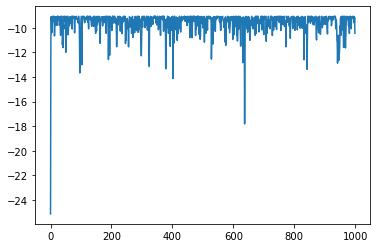

In [219]:
plt.plot(jlls.detach().numpy())